In [2]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.2 MB/s eta 0:00:00


In [3]:
import nltk
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load 20 Newsgroups dataset
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = newsgroups_data.data

# Preprocess text
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Apply preprocessing to all documents
processed_docs = [preprocess(doc) for doc in documents]

# Create a dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Apply LDA model
lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Print the topics discovered
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

# Visualize topics
lda_visualization = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_visualization)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Topic 1: 0.047*"max" + 0.045*"p" + 0.043*"r" + 0.040*"g" + 0.039*"q" + 0.034*"n" + 0.029*"b" + 0.029*"w" + 0.028*"c" + 0.025*"e"
Topic 2: 0.015*"would" + 0.012*"one" + 0.012*"get" + 0.011*"like" + 0.010*"know" + 0.010*"ha" + 0.008*"doe" + 0.008*"wa" + 0.007*"good" + 0.006*"could"
Topic 3: 0.020*"space" + 0.009*"earth" + 0.008*"launch" + 0.008*"mission" + 0.007*"orbit" + 0.007*"satellite" + 0.007*"nasa" + 0.007*"moon" + 0.006*"planet" + 0.006*"v"
Topic 4: 0.023*"game" + 0.015*"team" + 0.014*"wa" + 0.010*"year" + 0.009*"player" + 0.007*"season" + 0.006*"play" + 0.006*"last" + 0.006*"hockey" + 0.005*"league"
Topic 5: 0.027*"wa" + 0.009*"people" + 0.008*"one" + 0.006*"would" + 0.005*"time" + 0.005*"said" + 0.005*"year" + 0.004*"ha" + 0.004*"child" + 0.004*"day"
Topic 6: 0.013*"image" + 0.010*"system" + 0.008*"file" + 0.008*"data" + 0.008*"available" + 0.008*"information" + 0.007*"program" + 0.007*"software" + 0.006*"also" + 0.006*"use"
Topic 7: 0.032*"x" + 0.024*"window" + 0.017*"file" + 0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


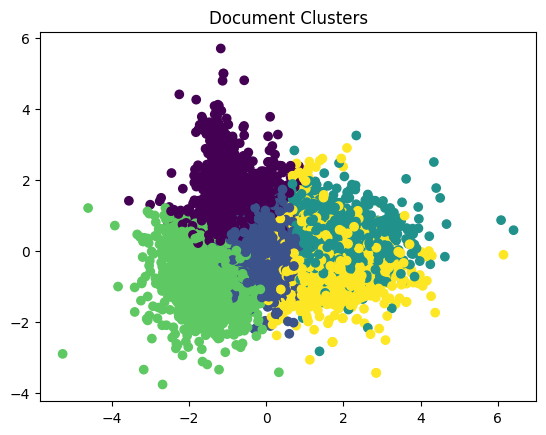

In [5]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=processed_docs, vector_size=100, window=5, min_count=5, workers=4)

# Function to calculate the document vector by averaging word vectors
def document_vector(doc):
    # Filter words that are in the Word2Vec model's vocabulary
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]

    # Return the mean of the vectors, or a zero vector if the document has no valid words
    if len(doc) > 0:
        return np.mean(word2vec_model.wv[doc], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Calculate document vectors
doc_vectors = np.array([document_vector(doc) for doc in processed_docs])

# Filter out empty vectors
doc_vectors = np.array([vec for vec in doc_vectors if np.any(vec)])

# Calculate cosine similarity
cosine_sim_matrix = cosine_similarity(doc_vectors)

# Clustering documents based on similarity
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(doc_vectors)
labels = kmeans.labels_

# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_vecs = pca.fit_transform(doc_vectors)

plt.scatter(reduced_vecs[:, 0], reduced_vecs[:, 1], c=labels, cmap='viridis')
plt.title('Document Clusters')
plt.show()
